## Implementation Steps

1. **Data Loading**: Using `pandas` to load and handle the dataset.
2. **Data Splitting**: Dividing the dataset into training and testing sets with `train_test_split`.
3. **Pipeline Creation**: Assembling a preprocessing pipeline with `ColumnTransformer` and appending the `RandomForestClassifier` at the end.
4. **Model Training and Prediction**: Fitting the model to the training data and making predictions on the test set.
5. **Results Visualization**: Plotting a confusion matrix using `seaborn` to visualize the prediction accuracy.


In [2]:
pip install -U imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline


## Loading the Dataset

In [2]:
df = pd.read_csv('NYPD_Arrest_Data__Year_to_Date_.csv')

## Data Cleaning

In [3]:
dataset_overview = {
    "Total Records": df.shape[0],
    "Total Columns": df.shape[1],
    "Unique Arrest Dates": df["ARREST_DATE"].nunique()
}
dataset_overview

{'Total Records': 112571, 'Total Columns': 19, 'Unique Arrest Dates': 181}

In [4]:
columns_data_types = df.dtypes
columns_data_types

ARREST_KEY                    int64
ARREST_DATE                  object
PD_CD                       float64
PD_DESC                      object
KY_CD                       float64
OFNS_DESC                    object
LAW_CODE                     object
LAW_CAT_CD                   object
ARREST_BORO                  object
ARREST_PRECINCT               int64
JURISDICTION_CODE             int64
AGE_GROUP                    object
PERP_SEX                     object
PERP_RACE                    object
X_COORD_CD                    int64
Y_COORD_CD                    int64
Latitude                    float64
Longitude                   float64
New Georeferenced Column     object
dtype: object

In [5]:
missing_values = df.isnull().sum()
missing_values

ARREST_KEY                    0
ARREST_DATE                   0
PD_CD                       461
PD_DESC                       0
KY_CD                       466
OFNS_DESC                     0
LAW_CODE                      0
LAW_CAT_CD                  846
ARREST_BORO                   0
ARREST_PRECINCT               0
JURISDICTION_CODE             0
AGE_GROUP                     0
PERP_SEX                      0
PERP_RACE                     0
X_COORD_CD                    0
Y_COORD_CD                    0
Latitude                      0
Longitude                     0
New Georeferenced Column      0
dtype: int64

In [6]:
data = df
def replace_missing_with_random(df, column, data_type='numeric'):
    if df[column].isnull().sum() > 0:
        if data_type == 'numeric':
            values_range = df[column].dropna().unique()
            random_values = np.random.choice(values_range, size=df[column].isnull().sum())
        elif data_type == 'categorical':
            unique_values = df[column].dropna().unique()
            random_values = np.random.choice(unique_values, size=df[column].isnull().sum())
        df.loc[df[column].isnull(), column] = random_values

# Replacing missing values in 'PD_CD' and 'KY_CD' (numeric columns)
replace_missing_with_random(data, 'PD_CD', data_type='numeric')
replace_missing_with_random(data, 'KY_CD', data_type='numeric')

# Replacing missing values in 'LAW_CAT_CD' (categorical column)
replace_missing_with_random(data, 'LAW_CAT_CD', data_type='categorical')

# Verifying the replacements
missing_values_after_replacements = data.isnull().sum()

missing_values_after_replacements, data.head()

(ARREST_KEY                  0
 ARREST_DATE                 0
 PD_CD                       0
 PD_DESC                     0
 KY_CD                       0
 OFNS_DESC                   0
 LAW_CODE                    0
 LAW_CAT_CD                  0
 ARREST_BORO                 0
 ARREST_PRECINCT             0
 JURISDICTION_CODE           0
 AGE_GROUP                   0
 PERP_SEX                    0
 PERP_RACE                   0
 X_COORD_CD                  0
 Y_COORD_CD                  0
 Latitude                    0
 Longitude                   0
 New Georeferenced Column    0
 dtype: int64,
    ARREST_KEY ARREST_DATE  PD_CD              PD_DESC  KY_CD OFNS_DESC   
 0   263238742  02/08/2023  380.0  ROBBERY,CAR JACKING  105.0   ROBBERY  \
 1   265590985  03/24/2023  155.0               RAPE 2  104.0      RAPE   
 2   265798132  03/28/2023  157.0               RAPE 1  104.0      RAPE   
 3   269233687  06/02/2023  157.0               RAPE 1  104.0      RAPE   
 4   270519574  06/28

In [7]:
unique_values = df.nunique()
unique_values

ARREST_KEY                  112571
ARREST_DATE                    181
PD_CD                          243
PD_DESC                        233
KY_CD                           66
OFNS_DESC                       63
LAW_CODE                       923
LAW_CAT_CD                       5
ARREST_BORO                      5
ARREST_PRECINCT                 77
JURISDICTION_CODE               22
AGE_GROUP                        5
PERP_SEX                         3
PERP_RACE                        7
X_COORD_CD                   22160
Y_COORD_CD                   23202
Latitude                     26457
Longitude                    26469
New Georeferenced Column     26963
dtype: int64

# RandomForest Classifier with Preprocessing Pipeline

In [4]:


# Separate features and target variable
X = df.drop('OFNS_DESC', axis=1)  # Assuming 'OFNS_DESC' is the target variable
y = df['OFNS_DESC']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Create a pipeline with the preprocessor and the RandomForestClassifier
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

Accuracy: 0.9983122112993011


## Confusion Matrix Visualization

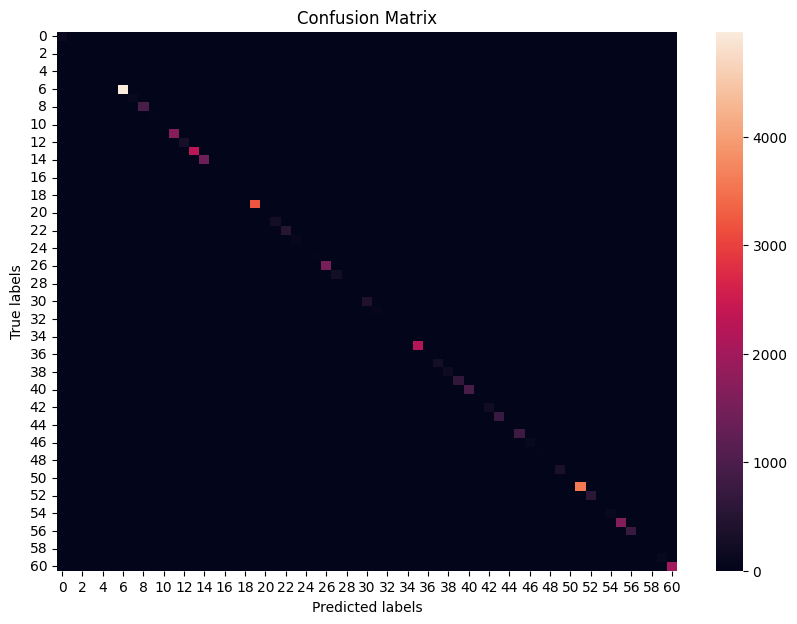

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming your model is already trained and you have X_test and y_test
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

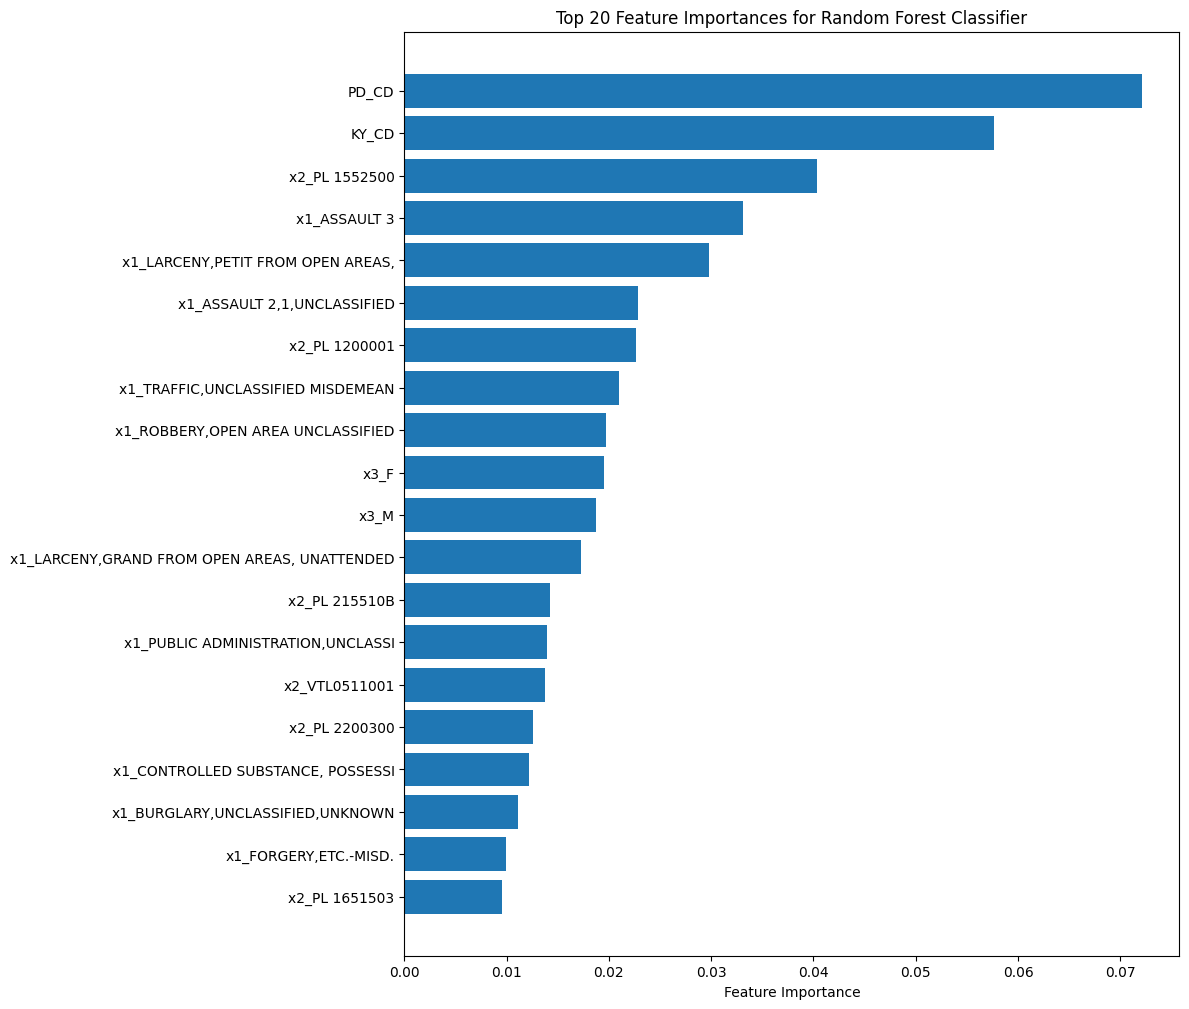

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your trained Pipeline model as before

# Extract feature importances
feature_importances = model.named_steps['classifier'].feature_importances_

# Get feature names
preprocessor = model.named_steps['preprocessor']
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()

# Combine feature names
feature_names = np.concatenate([num_features, cat_features])

# Sort the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]  # Descending order

# Select a number of top features to display
top_n = 20  # For example, the top 20 features
top_sorted_indices = sorted_indices[:top_n]

# Plotting the top N feature importances
plt.figure(figsize=(10, 12))
plt.barh(range(len(top_sorted_indices)), feature_importances[top_sorted_indices], align='center')
plt.yticks(range(len(top_sorted_indices)), feature_names[top_sorted_indices])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances for Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


## Correlation Heatmap

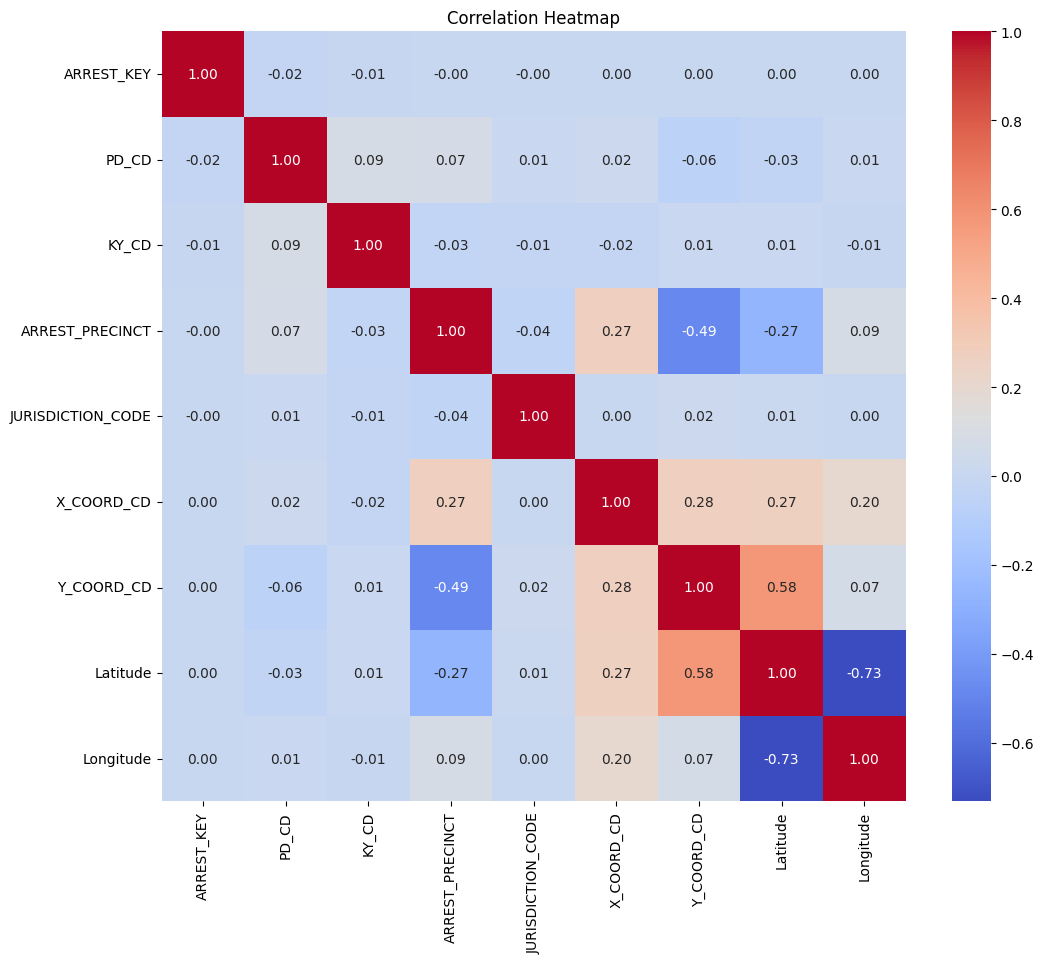

In [7]:
corr = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [8]:

# Convert 'OFNS_DESC' into a binary target variable
df['target_crime'] = df['OFNS_DESC'].apply(lambda x: 1 if x == 'RAPE' else 0)

# Check the balance of the target variable
print(df['target_crime'].value_counts())

# Define features and target
X = df[['ARREST_PRECINCT', 'AGE_GROUP', 'PERP_SEX']]  # Example features
y = df['target_crime']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['ARREST_PRECINCT']),
        ('cat', OneHotEncoder(), ['AGE_GROUP', 'PERP_SEX'])
    ])

# Create a pipeline with SMOTE and Logistic Regression
model = ImbPipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),
                           ('classifier', LogisticRegression())])

# Splitting the data with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the balance of the target variable in the training set
print(y_train.value_counts())

# Fit and evaluate the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

0    112212
1       359
Name: target_crime, dtype: int64
0    89774
1      282
Name: target_crime, dtype: int64
Mean Squared Error: 0.677770375305352


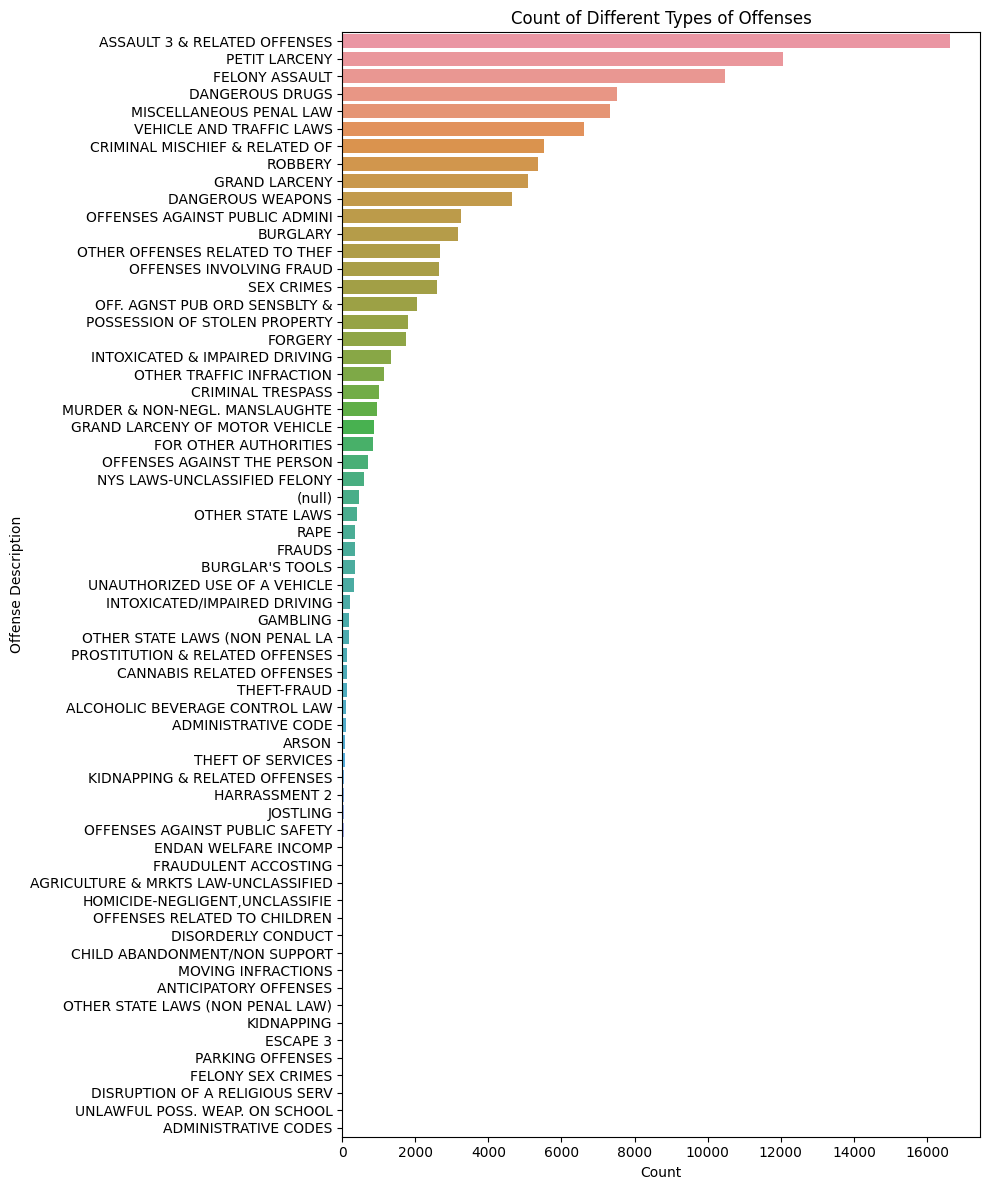

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase the figure size for better readability
plt.figure(figsize=(10, 12))

# Create the countplot with ordered categories based on their count
sns.countplot(y='OFNS_DESC', data=df, order=df['OFNS_DESC'].value_counts().index)

# Improve the y-axis labels with better spacing
plt.ylabel('Offense Description')
plt.xlabel('Count')
plt.title('Count of Different Types of Offenses')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

# Optionally, you can rotate the y-axis labels to be horizontal, which sometimes helps with spacing
plt.yticks(rotation=0)

plt.show()


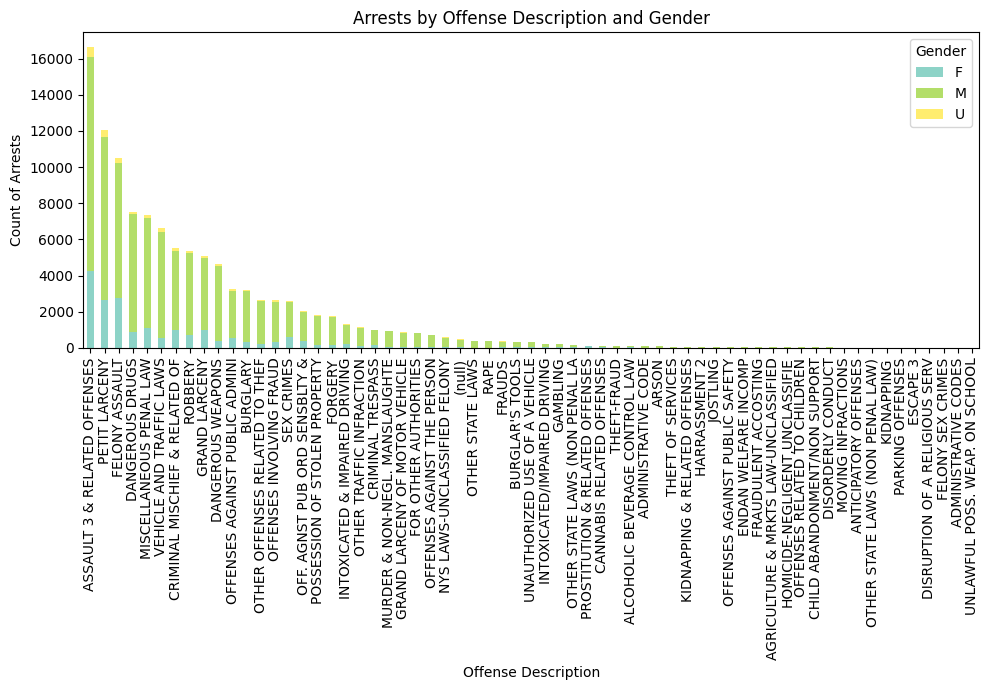

In [10]:
import matplotlib.pyplot as plt

# Create a pivot table with counts of arrests for each offense description and gender
pivot_df = df.pivot_table(index='OFNS_DESC', columns='PERP_SEX', values='AGE_GROUP', aggfunc='count', fill_value=0)

# Sort the pivot table by the total count of arrests (sum of both genders) in descending order
pivot_df['Total'] = pivot_df['F'] + pivot_df['M']
pivot_df = pivot_df.sort_values(by='Total', ascending=False)
pivot_df.drop(columns='Total', inplace=True)

# Create a stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='Set3')

# Add labels and title
plt.xlabel('Offense Description')
plt.ylabel('Count of Arrests')
plt.title('Arrests by Offense Description and Gender')

# Adjust the legend
plt.legend(title='Gender', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
pip install folium


In [12]:
import folium
import pandas as pd

# Create a Folium Map centered around a specific location (e.g., New York City)
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Create a list of markers using a list comprehension
markers = [
    folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        popup=row['OFNS_DESC'],  # Display offense description as popup
        icon=folium.Icon(icon='info')
    )
    for _, row in df.iterrows()
]

# Add all markers to the map at once using folium.FeatureGroup
marker_cluster = folium.FeatureGroup(name='Arrests')
for marker in markers:
    marker.add_to(marker_cluster)
marker_cluster.add_to(nyc_map)

# Add a LayerControl to toggle the marker cluster
folium.LayerControl().add_to(nyc_map)

# Save the map as an HTML file or display it in Jupyter Notebook
nyc_map.save('nyc_arrests_map.html')

# Display the map (if using Jupyter Notebook)
nyc_map


In [ ]:
import matplotlib.pyplot as plt

# Count the number of arrests by gender
gender_counts = df['PERP_SEX'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Arrests by Gender')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract the day of the week from the arrest date
df['Day_of_Week'] = df['ARREST_DATE'].dt.day_name()

# Count the number of arrests by day of the week
day_of_week_counts = df['Day_of_Week'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
day_of_week_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Day of the Week')
plt.xticks(rotation=45)
plt.show()


In [15]:
import folium
from folium.plugins import HeatMap

# Create a map centered on New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Create a HeatMap layer based on the latitude and longitude
heat_data = df[['Latitude', 'Longitude']].values
HeatMap(heat_data).add_to(m)

# Display the map
m.save('arrests_heatmap.html')


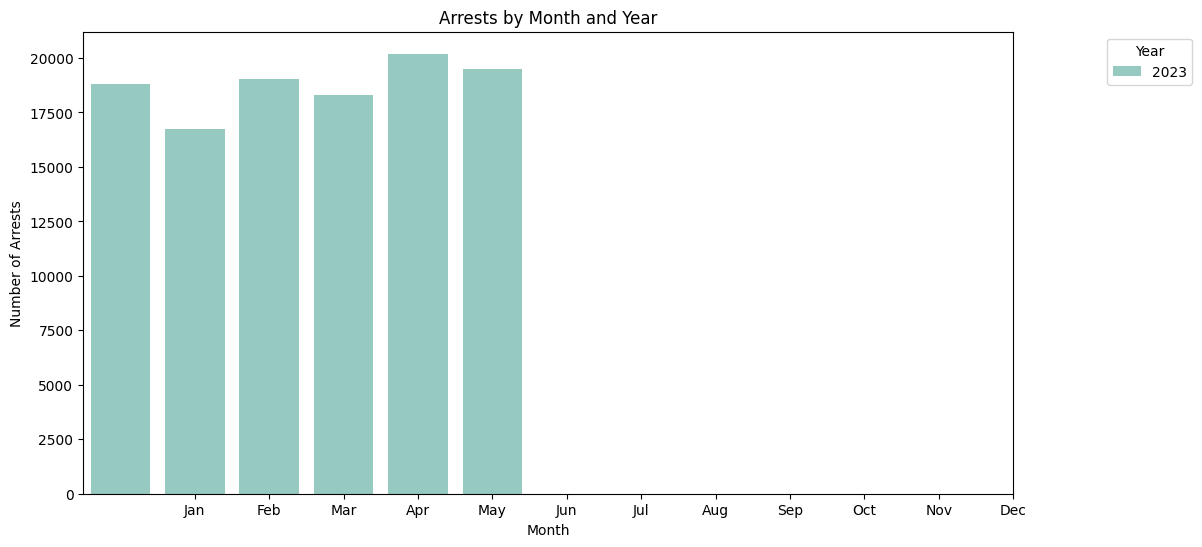

In [19]:
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'], format='%m/%d/%Y')

# Extract the year and month from the arrest date
df['Year'] = df['ARREST_DATE'].dt.year
df['Month'] = df['ARREST_DATE'].dt.month

# Create a bar chart of arrests by month and year
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Month', hue='Year', palette='Set3')
plt.xlabel('Month')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Month and Year')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

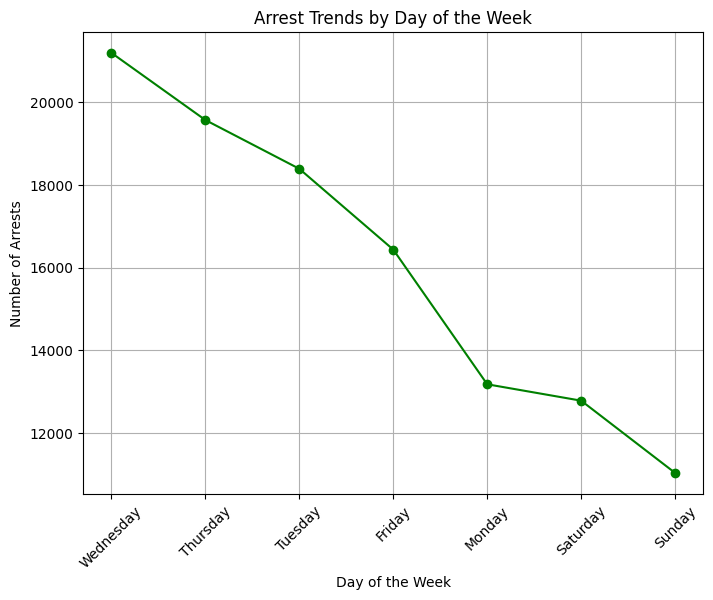

In [20]:
import matplotlib.pyplot as plt

# Extract the day of the week from the arrest date
df['Day_of_Week'] = df['ARREST_DATE'].dt.day_name()

# Count the number of arrests by day of the week
day_of_week_counts = df['Day_of_Week'].value_counts()

# Create a line plot
plt.figure(figsize=(8, 6))
day_of_week_counts.plot(kind='line', marker='o', color='green')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Arrests')
plt.title('Arrest Trends by Day of the Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [21]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Assuming you have a DataFrame called 'df' with 'Latitude' and 'Longitude' columns

# Calculate the number of arrests in each location
location_counts = df.groupby(['Latitude', 'Longitude']).size().reset_index(name='ArrestCount')

# Sort the locations by the number of arrests in descending order
top_10_locations = location_counts.nlargest(10, 'ArrestCount')

# Create a map centered on New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Create a marker cluster for the top 10 locations
marker_cluster = MarkerCluster().add_to(m)

# Add markers for the top 10 locations to the marker cluster
for index, row in top_10_locations.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        icon=None,
        popup=f"Arrests: {row['ArrestCount']}",
    ).add_to(marker_cluster)

# Display the map
m.save('top_10_crime_areas.html')
